## Import packages, .csv files

In [ ]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.cross_decomposition import CCA

from keras.layers import Input
from keras.callbacks import EarlyStopping
from keras.models import Sequential,Model
from keras.layers import Dense
from keras import layers,models
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
# Turn off warning for overwritting dataframe copies
pd.options.mode.chained_assignment = None

# Convert training .csv file into dataframe
df = pd.read_csv('/content/drive/MyDrive/house-prices/data/train.csv')

# Set dataframe index to 'ID' column
df = df.set_index('Id')

In [ ]:
# Print shape of data
df_shape = df.shape
print(f"# Rows = {df_shape[0]}")
print(f"# Cols = {df_shape[1]}")

# Rows = 1460
# Cols = 80


## Remove houses with above grade square footage greater than 4000

**Note from the author of the Ames Housing dataset:**
> "Potential Pitfalls (Outliers): Although all known errors were corrected in the data, no observations have been removed due to unusual values and all final residential sales from the initial data set are included in the data presented with this article. There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). **I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.**"

Source: [Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project](http://jse.amstat.org/v19n3/decock.pdf) (see page 4)

Text(0.5, 1.0, 'Above Grade Square Footage vs. Sale Price (Training)')

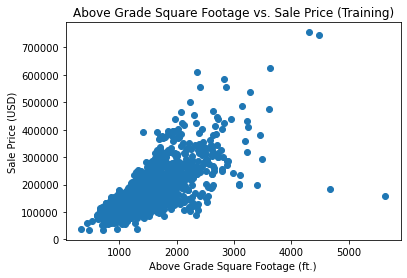

In [ ]:
# Plot above grade square footage vs. sale price
plt.scatter(df['GrLivArea'], df['SalePrice'])
plt.xlabel('Above Grade Square Footage (ft.)')
plt.ylabel('Sale Price (USD)')
plt.title('Above Grade Square Footage vs. Sale Price (Training)')

In [ ]:
# Filter out all homes with an above-grade square footage greater than 4000
df = df[df['GrLivArea'] < 4000]
houseData=df

Text(0.5, 1.0, 'Above Grade Square Footage vs. Sale Price (Training)')

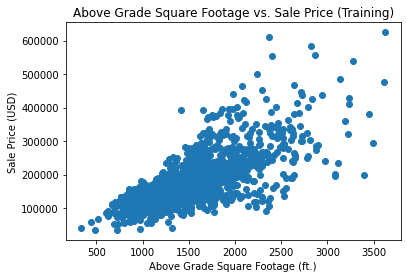

In [ ]:
# Plot above grade square footage vs. sale price (with influential points removed)
plt.scatter(df['GrLivArea'], df['SalePrice'])
plt.xlabel('Above Grade Square Footage (ft.)')
plt.ylabel('Sale Price (USD)')
plt.title('Above Grade Square Footage vs. Sale Price (Training)')

### Pearson Correlation Coefficient Heatmap

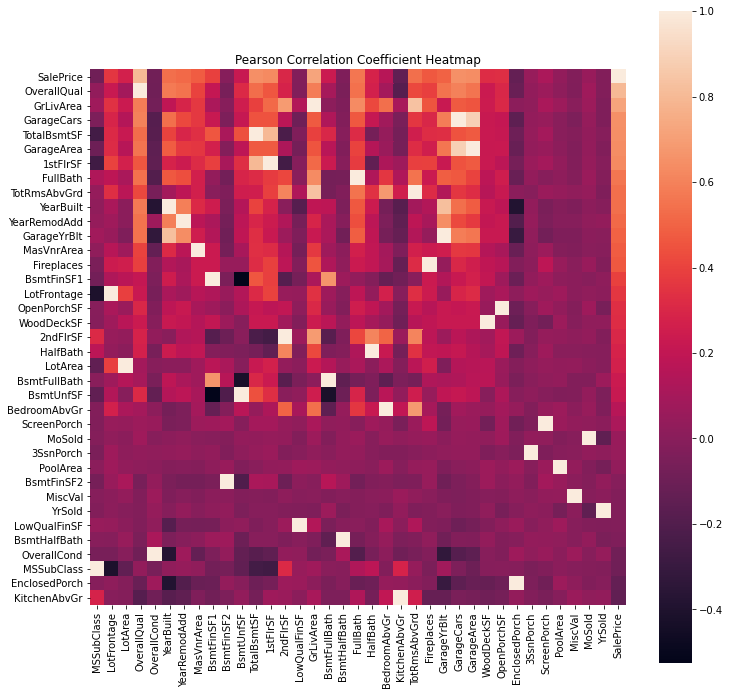

In [ ]:
# Pearson correlation coefficient heatmap 
PCCH = df.corr().sort_values(by='SalePrice', ascending=False)
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
plt.title('Pearson Correlation Coefficient Heatmap')
sns.heatmap(PCCH, square=True)

## Replace Missing Data

In [ ]:
# List of columns with missing values
if df.isnull().values.any():
  x = df.columns[df.isna().any()].tolist()
  for row in x:
    print(row)
else:
  print('No empty values')

LotFrontage
Alley
MasVnrType
MasVnrArea
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Electrical
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
MiscFeature


In [ ]:
# Construct training set (first 80% of entire dataset)
split_at = round(df.shape[0] * 0.8)
train = df.iloc[:split_at,:]

In [ ]:
### Determine how to replace LotFrontage ###

# Drop rows with missing LotFrontage
a = train.dropna(subset=['LotFrontage'])

# Create dataframe with LotFrontage and LotArea (from training set only)
a = a[['LotFrontage', 'LotArea']]

# Confirm all empty rows have been deleted
if a.isnull().values.any():
  x = a.columns[a.isna().any()].tolist()
  print('Empty rows:')
  for row in x:
    print(row)
  raise SystemExit()

# Create new column: sqrt(LotArea)
a['SqrtLotArea'] = np.sqrt(a['LotArea'])

# Get the mean of the LotFrontage
LotFrontage_mean = a['LotFrontage'].mean()

# Create a new column: abs(LotFrontage - SqrtLotArea)
a['AbsSqrt'] = np.abs(a['LotFrontage'] - a['SqrtLotArea'])

# Create a new column: abs(LotFrontage - LotFrontage_mean)
a['AbsMean'] = np.abs(a['LotFrontage'] - LotFrontage_mean)

# Take the mean of AbsSqrtLotFrontage
AbsSqrt_mean = a['AbsSqrt'].mean()

# Take the mean of AbsMeanLotFrontage
AbsMean_mean = a['AbsMean'].mean()

# Print mean of AbsSqrtLotFrontage and AbsMeanLotFrontage (take lesser value)
print(f"abs(LotFrontage - sqrt(LotArea))\t= {AbsSqrt_mean}")
print(f"abs(LotFrontage - mean(LotFrontage))\t= {AbsMean_mean}")

abs(LotFrontage - sqrt(LotArea))	= 27.934035463227552
abs(LotFrontage - mean(LotFrontage))	= 16.511786151937464


In [ ]:
# Replace missing LotFrontage value with mean of df_80['LotFrontage']
df['LotFrontage'] = df['LotFrontage'].fillna(LotFrontage_mean)

# Replace missing with 'None'
df['Alley'] = df['Alley'].fillna("None")
df['GarageType'] = df['GarageType'].fillna("None")
df['MiscFeature'] = df['MiscFeature'].fillna("None")
df['MasVnrType'] = df['MasVnrType'].fillna("None")

# Replace missing with mode of training set
df['Electrical'] = df['Electrical'].fillna(train['Electrical'].mode()[0])

# Replace missing with mean of training set
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())

# Replace missing with 0
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['BsmtQual'] = df['BsmtQual'].fillna(0)
df['BsmtCond'] = df['BsmtCond'].fillna(0)
df['BsmtExposure'] = df['BsmtExposure'].fillna(0)
df['BsmtFinType1'] = df['BsmtFinType1'].fillna(0)
df['BsmtFinType2'] = df['BsmtFinType2'].fillna(0)
df['FireplaceQu'] = df['FireplaceQu'].fillna(0)
df['GarageFinish'] = df['GarageFinish'].fillna(0)
df['GarageQual'] = df['GarageQual'].fillna(0)
df['GarageCond'] = df['GarageCond'].fillna(0)
df['PoolQC'] = df['PoolQC'].fillna(0)
df['Fence'] = df['Fence'].fillna(0)

In [ ]:
# Verify all missing rows have been filled
if df.isnull().values.any():
  print("The following values have not been filled:")
  x = df.columns[df.isna().any()].tolist()
  for row in x:
    print(row)
else:
  print('No empty values')

No empty values


## Convert MSSubClass to Categorical

In [ ]:
# Convert MSSubClass to categorical
replacement = {
    'MSSubClass': {
        20: '1-STORY 1946 & NEWER ALL STYLES',
        30: '1-STORY 1945 & OLDER',
        40: '1-STORY W/FINISHED ATTIC ALL AGES',
        45: '1-1/2 STORY - UNFINISHED ALL AGES',
        50: '1-1/2 STORY FINISHED ALL AGES',
        60: '2-STORY 1946 & NEWER',
        70: '2-STORY 1945 & OLDER',
        75: '2-1/2 STORY ALL AGES',
        80: 'SPLIT OR MULTI-LEVEL',
        85: 'SPLIT FOYER',
        90: 'DUPLEX - ALL STYLES AND AGES',
        120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
        150: '1-1/2 STORY PUD - ALL AGES',
        160: '2-STORY PUD - 1946 & NEWER',
        180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
        190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
    }
}
df = df.replace(replacement)

## Ordinal Encoding

In [ ]:
# List of features to be ordinal encoded
ordinal_features = [
       'ExterQual',
       'ExterCond',
       'BsmtQual',
       'BsmtCond',
       'BsmtExposure',
       'BsmtFinType1',
       'BsmtFinType2',
       'HeatingQC',
       'KitchenQual',
       'Functional',
       'FireplaceQu',
       'GarageFinish',
       'GarageQual',
       'GarageCond',
       'PoolQC',
       'Neighborhood',
       'CentralAir'
]

In [ ]:
# Confirm above features have not been ordinal encoded:
ord_data = df[ordinal_features]
tmp = ord_data[ord_data.dtypes[ord_data.dtypes == 'object'].index]
if (len(list(tmp)) == 0):
  print("All columns have been encoded.")
else:
  print('The following columns have not been encoded:')
  for column in list(tmp):
    print(column)

The following columns have not been encoded:
ExterQual
ExterCond
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
HeatingQC
KitchenQual
Functional
FireplaceQu
GarageFinish
GarageQual
GarageCond
PoolQC
Neighborhood
CentralAir


In [ ]:
# Perform ordinal encoding
qual = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
bsmt_fin_type = {'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
replacement = {
    'ExterQual': qual,
    'ExterCond': qual,
    'BsmtQual': qual,
    'BsmtCond': qual,
    'HeatingQC': qual,
    'KitchenQual': qual,
    'FireplaceQu': qual,
    'GarageQual': qual,
    'GarageCond': qual,
    'BsmtFinType1': bsmt_fin_type,
    'BsmtFinType2': bsmt_fin_type,
    'Functional': {
        'Sal': 1,
        'Sev': 2,
        'Maj2': 3,
        'Maj1': 4,
        'Mod': 5,
        'Min2': 6,
        'Min1': 7,
        'Typ': 8
    },
    'GarageFinish': {
        'Unf': 1,
        'RFn': 2,
        'Fin': 3
    },
    'PoolQC': {
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    },
    'BsmtExposure': {
        'No': 1,
        'Mn': 2,
        'Av': 3,
        'Gd': 4
    },
    'CentralAir': {
        'N': 0,
        'Y': 1
    }
}
df = df.replace(replacement)

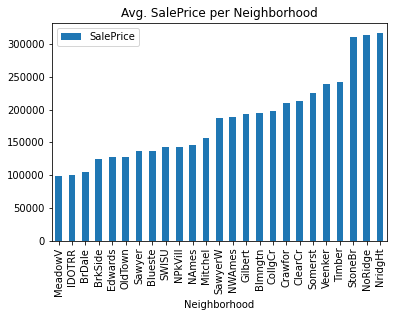

In [ ]:
# Show vertical plot of average SalePrice per Neighborhood (ascending order)
avg_price = df.groupby('Neighborhood')['SalePrice'].mean()
avg_price_df = avg_price.to_frame()
avg_price_df_sorted = avg_price_df.sort_values(by='SalePrice')
avg_price_df_sorted.plot(kind="bar", title="Avg. SalePrice per Neighborhood")

In [ ]:
# Convert Neighborhood to Ordinal
neighborhood_replacement = {'Neighborhood': {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'Edwards': 2,
    'OldTown': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 3,
    'SawyerW': 4,
    'NWAmes': 4,
    'Gilbert': 4,
    'Blmngtn': 4,
    'CollgCr': 4,
    'Crawfor': 5,
    'ClearCr': 5,
    'Somerst': 5,
    'Veenker': 6,
    'Timber': 6,
    'StoneBr': 7,
    'NoRidge': 7,
    'NridgHt': 7
}}
df = df.replace(neighborhood_replacement)

In [ ]:
# Confirm ordinal features have been encoded:
ord_data = df[ordinal_features]
tmp = ord_data[ord_data.dtypes[ord_data.dtypes == 'object'].index]
if (len(list(tmp)) == 0):
  print("All columns have been encoded.")
else:
  print('The following columns have not been encoded:')
  for column in list(tmp):
    print(column)

All columns have been encoded.


## Drop Columns

In [ ]:
# Shape of data before dropping columns
df.shape

(1456, 80)

In [ ]:
# Drop columns (mismatch in col number after dummy encoding)
del df['SaleCondition']
del df['SaleType']
del df['Condition2']
del df['Electrical']
del df['MiscFeature']
del df['Exterior1st']
del df['Exterior2nd']
del df['Condition1']
del df['MSSubClass']
del df['RoofMatl']
del df['Utilities']
del df['Heating']
del df['RoofStyle']

In [ ]:
# Shape of data after dropping columns
df.shape

(1456, 67)

## Dummy Encoding

In [ ]:
# Generate dataframe for numerical features only (used in MinMaxScaler below)
numerical_features = df[df.dtypes[df.dtypes != 'object'].index]

In [ ]:
# Shape of data prior to dummy variable encoding
print("Shape of data prior to dummy encoding:")
df_shape = df.shape
print(f"Rows = {df_shape[0]}")
print(f"Cols = {df_shape[1]}")
print("")

# List of categorical features
nom_data = df[df.dtypes[df.dtypes == 'object'].index]
if (len(list(nom_data)) == 0):
  print("All columns have been encoded.")
else:
  print("List of categorical features:")
  for feature in list(nom_data):
    print(feature)

Shape of data prior to dummy encoding:
Rows = 1456
Cols = 67

List of categorical features:
MSZoning
Street
Alley
LotShape
LandContour
LotConfig
LandSlope
BldgType
HouseStyle
MasVnrType
Foundation
GarageType
PavedDrive
Fence


In [ ]:
# Perform dummy encoding
df = pd.get_dummies(df)

In [ ]:
# Shape of data after to dummy variable encoding
print("Shape of data aftert dummy encoding:")
df_shape = df.shape
print(f"Rows = {df_shape[0]}")
print(f"Cols = {df_shape[1]}")
print("")

# List of categorical features
nom_data = df[df.dtypes[df.dtypes == 'object'].index]
if (len(list(nom_data)) == 0):
  print("All columns have been encoded.")
else:
  print("List of categorical features:")
  for feature in list(nom_data):
    print(feature)

Shape of data aftert dummy encoding:
Rows = 1456
Cols = 117

All columns have been encoded.


## Feature Engineering

In [ ]:
#Feature Engineering
#Construct new features of out existing data

# TotalSF = GrLivArea + TotalBsmtSF            
# Total square footage of house
df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']

# TotalBath = BsmtFullBath + BsmtHalfBath + FullBath + HalfBath    
# Number of bathrooms in house
df['TotalBath'] = df['BsmtFullBath'] + df['BsmtHalfBath'] + df['FullBath'] + df['HalfBath']

# Age_Sold =  (YrSold + MoSold/12) - YearBuilt    
# Age of house when sold
df['Age_Sold'] = df['YrSold'] + df['MoSold']/12 - df['YearBuilt']

# TotalPorchSF = OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch
# Aggregate square footage of all types of porches
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

# Age_Remod = (YrSold + MoSold/12) - YearRemodAdd
# Ammount of time elapsed between sale and remodelling. 
df['Age_Remod'] = df['YrSold'] + df['MoSold']/12 - df['YearRemodAdd']

# Garage_Age = (YrSold + MoSold/12) - YearRemodAdd
# Age of the garage when sold
df['Garage_Age'] = df['YrSold'] + df['MoSold']/12 - df['GarageYrBlt']

# Drop redundant features with high values (the Year features)
df = df.drop(['YearBuilt','YearRemodAdd','YrSold','GarageYrBlt'], axis=1)

In [ ]:
# Log Transform the Price
# Compress the range of prices and also decrease the right-skewedness of the distribution  
df['SalePrice'] = np.log(df['SalePrice'])

# Log transform large, non-negative, numeric values to compress them into similar ranges
# Any value that is an area increases quadratically with length such that even variables that 
# are approximately linear in length will tend to be right-skewed. Log transform can help alleviate this.
# If a feature has any zero values, instead use log1p so that 0 maps to 0 rather than -inf
log_feat = ["LotArea","LotFrontage","1stFlrSF","GrLivArea","TotalSF","Age_Sold"]
for log_i in log_feat:
  df[log_i] = np.log(df[log_i])

log1p_feat = ["MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","2ndFlrSF","LowQualFinSF","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","TotalPorchSF"]
for log1p_i in log1p_feat:
  df[log1p_i] = np.log1p(df[log1p_i])

In [ ]:
dummy_features_list = list(set(list(df)) - set(list(numerical_features)))

# Remove all dummy features
non_dummy_features_list = list(set(list(df)) - set(dummy_features_list))

# Remove SalePrice and CentralAir
non_dummy_features_list.remove('SalePrice')
non_dummy_features_list.remove('CentralAir')

# Add Custom Features
non_dummy_features_list.append('TotalSF')
non_dummy_features_list.append('TotalBath')
non_dummy_features_list.append('Age_Sold')
non_dummy_features_list.append('TotalPorchSF')
non_dummy_features_list.append('Age_Remod')
non_dummy_features_list.append('Garage_Age')

# Apply MinMaxScaler
df[non_dummy_features_list] = MinMaxScaler().fit_transform(df[non_dummy_features_list])

In [ ]:
# Split data 80/20
split_at = round(df.shape[0] * 0.8)

train = df.iloc[:split_at,:]
test = df.iloc[split_at:,:]

# Print shape of data
print("Training data:")
print("# rows =", train.shape[0])
print("# cols =", train.shape[1])

print("Test data:")
print("# rows =", test.shape[0])
print("# cols =", test.shape[1])

Training data:
# rows = 1165
# cols = 119
Test data:
# rows = 291
# cols = 119


In [ ]:
#look at data
train['SalePrice']

Id
1       12.247694
2       12.109011
3       12.317167
4       11.849398
5       12.429216
          ...    
1163    11.767568
1164    11.598727
1165    12.175613
1166    12.359523
1167    12.410441
Name: SalePrice, Length: 1165, dtype: float64

In [ ]:
#Get the 20 most important features based on Pearson coerrelation coefficients
abs(PCCH["SalePrice"]).sort_values(ascending=False).head(20)

SalePrice       1.000000
OverallQual     0.800858
GrLivArea       0.720516
GarageCars      0.649256
TotalBsmtSF     0.646584
GarageArea      0.636964
1stFlrSF        0.625235
FullBath        0.559048
TotRmsAbvGrd    0.537462
YearBuilt       0.535279
YearRemodAdd    0.521428
GarageYrBlt     0.499230
MasVnrArea      0.478862
Fireplaces      0.466765
BsmtFinSF1      0.395923
LotFrontage     0.356773
OpenPorchSF     0.330361
WoodDeckSF      0.322538
2ndFlrSF        0.297301
HalfBath        0.282925
Name: SalePrice, dtype: float64

In [ ]:
#Get the 20 most important features based on Pearson coerrelation coefficients after including the engineered features
#This is evidence that 5 of the 6 features are better predictors of price than the features they were created from. Only TotalPorchSF is worse than OpenPorchSF
PCCH2 = train.corr().sort_values(by='SalePrice',ascending=False)
abs(PCCH2["SalePrice"]).sort_values(ascending=False).head(20)


SalePrice           1.000000
OverallQual         0.819796
TotalSF             0.815601
Neighborhood        0.744459
GrLivArea           0.744120
GarageCars          0.687685
ExterQual           0.682176
KitchenQual         0.671159
TotalBath           0.664328
Age_Sold            0.620498
BsmtQual            0.613174
1stFlrSF            0.608554
GarageFinish        0.601829
FullBath            0.600613
Age_Remod           0.584352
TotRmsAbvGrd        0.554271
FireplaceQu         0.549698
Foundation_PConc    0.537770
Garage_Age          0.516308
HeatingQC           0.487029
Name: SalePrice, dtype: float64

In [ ]:
#Benchmark LassoCV model
y_bench = train[['SalePrice']]
y_bench = np.ravel(y_bench)
X_bench = train.drop('SalePrice', axis=1)
bench_lasso = LassoCV(random_state=42).fit(X_bench, y_bench)
mean_squared_error(y_bench, bench_lasso.predict(X_bench), squared=False)

0.10658191102911108

In [ ]:
# Benchmark Linear Regression
bench_linear = LinearRegression().fit(X_bench, y_bench)
mean_squared_error(y_bench, bench_linear.predict(X_bench), squared=False)

0.10321469004066255

In [ ]:
# Benchmark SVR
bench_svr = SVR().fit(X_bench, y_bench)
mean_squared_error(y_bench, bench_svr.predict(X_bench), squared=False)

0.08670506927058688

In [ ]:
# The Complete Dataset 
# This dataset includes every feature, no feature selection besides replacing "Year" features with "Age" features has been applied directly to the dataset
y = y_bench
X_complete = X_bench 

In [ ]:
# The Sparse, Intuitive Dataset
# This dataset includes only the 11 most influencial features as determined by 
# Pearson Coefficients that are not: 1.) either part of a more influencial feature (e.g. GrLivArea) 
# or 2.) highly collinear with a more influential feature (e.g. GarageArea).
# This dataset is meant to have the highest interpretability even at the cost of some performance
X_Intuitive = train[['OverallQual', 'TotalSF','Neighborhood','GarageCars','ExterQual','KitchenQual','TotalBath','Age_Sold','BsmtQual','GarageFinish','Age_Remod']]
X_Intuitive

OverallQual   TotalSF  Neighborhood  ...  BsmtQual  GarageFinish  Age_Remod
Id                                         ...                                   
1        0.666667  0.689473      0.500000  ...       0.8      0.666667   0.084022
2        0.555556  0.683892      0.833333  ...       0.8      0.666667   0.517906
3        0.666667  0.707436      0.500000  ...       0.8      0.666667   0.110193
4        0.666667  0.676990      0.666667  ...       0.6      0.333333   0.596419
5        0.777778  0.778920      1.000000  ...       0.8      0.666667   0.147383
...           ...       ...           ...  ...       ...           ...        ...
1163     0.444444  0.567316      0.333333  ...       0.8      1.000000   0.650138
1164     0.333333  0.674657      0.333333  ...       0.8      0.333333   0.644628
1165     0.444444  0.718016      0.833333  ...       0.8      0.333333   0.486226
1166     0.666667  0.742764      1.000000  ...       0.8      0.666667   0.011019
1167     0.777778  0.783441      0.500000  ...       0.8      0.666667   0.034435

[1165 rows x 11 columns]

In [ ]:
#Benchmark LassoCV model on Sparse, Intuitive Dataset
bench_intuitive_lasso = LassoCV(random_state=42).fit(X_Intuitive, y)
mean_squared_error(y, bench_intuitive_lasso.predict(X_Intuitive), squared=False)

0.14086013981828524

In [ ]:
#Benchmark Linear Regression on Sparse, Intuitive Dataset
bench_intuitive_linear = LinearRegression().fit(X_Intuitive, y)
mean_squared_error(y, bench_intuitive_linear.predict(X_Intuitive), squared=False)

0.14081405046069498

In [ ]:
#Benchmark SVR on Sparse, Intuitive Dataset
bench_intuitive_SVR = SVR().fit(X_Intuitive, y)
mean_squared_error(y, bench_intuitive_SVR.predict(X_Intuitive), squared=False)

0.11764371656774346

In [ ]:
# Hyper-parameter tuning lasso on Complete Dataset
# Grid of alpha values evenly distributed in log10-space from 0.0001 to 1 
alpha_GS = np.logspace(-4,0,num=50)
lasso = Lasso(random_state = 42)
tuning_params_lasso = [{'alpha': alpha_GS}]
GS_lasso = GridSearchCV(lasso,tuning_params_lasso, refit=True,cv=15, verbose=0)
GS_lasso.fit(X_complete,y)
print(mean_squared_error(GS_lasso.predict(X_complete),y,squared=False))
print(GS_lasso.best_params_)

0.10440667691894724
{'alpha': 0.00014563484775012445}


In [ ]:
# Hyper-parameter tuning SVR
epsilon_GS = np.logspace(-4,-1,num=10)
svr = SVR()
C_GS = np.linspace(0.9,1.1,3)
tuning_params_SVR =[{'epsilon': epsilon_GS,'C':C_GS}]
GS_SVR = GridSearchCV(svr,tuning_params_SVR, refit=True,cv=5, verbose=0)
GS_SVR.fit(X_complete,y)
print(mean_squared_error(GS_SVR.predict(X_complete),y,squared=False))
print(GS_SVR.best_params_)

0.07127411937845056
{'C': 1.0, 'epsilon': 0.021544346900318822}


In [ ]:
# Rmse of hyper-parameter tuned lasso in dollars 
round(mean_squared_error(np.exp(GS_lasso.predict(X_complete)),np.exp(y),squared=False),2)

19908.94

In [ ]:
# Rmse of hyper-parameter tuned SVR in dollars 
round(mean_squared_error(np.exp(GS_SVR.predict(X_complete)),np.exp(y),squared=False),2)

14093.54

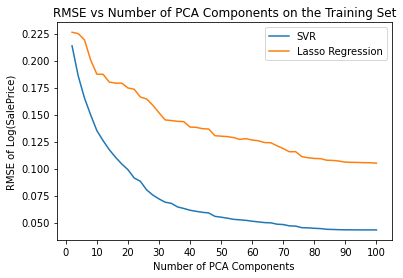

In [ ]:
# The PCA Dataset
# Evaluate the performance of the algorithms as the number of PCA components is increased
# Uses the hyper-parameter tuning results from the preceding section


pca_history = np.zeros((50,3))
for ii in range(1,51):
  pca = PCA(n_components = 2*ii)
  Principal_Components = pca.fit_transform(X_complete)
  pca_SVR = SVR(C=1,epsilon=0.0215443469).fit(Principal_Components, y)
  pca_rmse = mean_squared_error(y, pca_SVR.predict(Principal_Components), squared=False)
  pca_lasso = Lasso(alpha=0.0001456348).fit(Principal_Components, y)
  pca_lasso_rmse = mean_squared_error(y, pca_lasso.predict(Principal_Components), squared=False)
  pca_history[ii -1,0] = pca_rmse
  pca_history[ii -1,1] = 2*ii
  pca_history[ii -1,2] = pca_lasso_rmse


plt.plot(pca_history[:,1],pca_history[:,0], label='SVR')
plt.plot(pca_history[:,1],pca_history[:,2], label='Lasso Regression' )
plt.title('RMSE vs Number of PCA Components on the Training Set')
plt.xlabel('Number of PCA Components')
plt.ylabel('RMSE of Log(SalePrice)')
plt.xticks(np.linspace(0,100,11))
plt.legend()

In [ ]:
# testset
y_test = test[['SalePrice']]
y_test = np.ravel(y_test)

# Complete set using all features
X_test_complete = test.drop('SalePrice', axis=1)

# Intuitive set using only 11 features
X_test_Intuitive = test[['OverallQual', 'TotalSF','Neighborhood','GarageCars','ExterQual','KitchenQual','TotalBath','Age_Sold','BsmtQual','GarageFinish','Age_Remod']]


In [ ]:
# Lasso performance on test set including all features
# note rmse decreases in log-space but increases in dollars
GS_lasso.fit(X_test_complete,y_test)
print(mean_squared_error(GS_lasso.predict(X_test_complete),y_test,squared=False))
print(round(mean_squared_error(np.exp(GS_lasso.predict(X_test_complete)),np.exp(y_test),squared=False),2))

# Lasso performance on intuitive test set including only 11 features
print(mean_squared_error(bench_intuitive_lasso.predict(X_test_Intuitive),y_test,squared=False))
print(round(mean_squared_error(np.exp(bench_intuitive_lasso.predict(X_test_Intuitive)),np.exp(y_test),squared=False),2))

0.09963923758354228
20436.42
0.14451737827690894
27211.49


In [ ]:
# SVR performance on test set including all features
GS_SVR.fit(X_test_complete,y_test)
print(mean_squared_error(GS_SVR.predict(X_test_complete),y_test,squared=False))
print(round(mean_squared_error(np.exp(GS_SVR.predict(X_test_complete)),np.exp(y_test),squared=False),2))

# SVR performance on intuitive test set including only 11 features
print(mean_squared_error(bench_intuitive_SVR.predict(X_test_Intuitive),y_test,squared=False))
print(round(mean_squared_error(np.exp(bench_intuitive_SVR.predict(X_test_Intuitive)),np.exp(y_test),squared=False),2))

0.05399216584892046
13397.12
0.14639411928953672
27149.75


In [ ]:
# Use PCA to project down to 60 dimensions ~1/2 of the complete dataset's feature space
pca_perf = PCA(n_components = 60)
Principal_Components_perf = pca_perf.fit_transform(X_complete)
pca_SVR_perf = SVR(C=1,epsilon=0.0215443469).fit(Principal_Components_perf, y)
pca_lasso_perf = Lasso(alpha=0.0001456348).fit(Principal_Components_perf, y)
X_test_transformed = pca_perf.transform(X_test_complete)

# Evaluate SVR and lasso on balanced training set
print("Evaluate SVR and lasso on PCA training set:")
print("Lasso", mean_squared_error(y, pca_lasso_perf.predict(Principal_Components_perf), squared=False))
print("SVR", mean_squared_error(y, pca_SVR_perf.predict(Principal_Components_perf), squared=False))

# Evaluate lasso on balanced test set in log-space and in dollars
print("# Evaluate lasso on test set in log-space and in dollars:")
print(mean_squared_error(y_test, pca_lasso_perf.predict(X_test_transformed), squared=False))
print(mean_squared_error(np.exp(y_test), np.exp(pca_lasso_perf.predict(X_test_transformed)), squared=False))

# Evaluate SVR on balanced test set in log-space and in dollars
print("Evaluate SVR on test set in log-space and in dollars:")
print(mean_squared_error(y_test, pca_SVR_perf.predict(X_test_transformed), squared=False))
print(mean_squared_error(np.exp(y_test), np.exp(pca_SVR_perf.predict(X_test_transformed)), squared=False))


Evaluate SVR and lasso on PCA training set:
Lasso 0.12673058950359928
SVR 0.05141631444202799
# Evaluate lasso on test set in log-space and in dollars:
0.13861268762575735
26436.475986065972
Evaluate SVR on test set in log-space and in dollars:
0.147715076856788
30290.652730409856


#Neural Network Section

1. Three different Datasets for showing the importance of preprocessing

2. Hyperparameter

3. Cross-Validation (K-Fold) 

Hyperparameter Tuning with Keras Tuner

Many methods of hyperparameter tuning:

Tuning with Keras Tuner: Hypermodel is a keras tuner class that lets you define the model with a searchable space and build it.

Greedy Search: time and provcessing cost

Random Search: As the name suggests, this hyperparameter tuning method randomly tries a combination of hyperparameters from a given search space.

Hyperband: Hyperband is based on the algorithm by Li et. al. It optimizes random search method through adaptive resource allocation and early-stopping. Hyperband first runs random hyperparameter configurations for one iteration or two, then selects which configurations perform well, then continues tuning the best performers.

Bayesian Optimization: Bayesian optimization is a probabilistic model that maps the hyperparameters to a probability score on the objective function. Unlike Random Search and Hyperband models, Bayesian Optimization keeps track of its past evaluation results and uses it to build the probability model.

Cross Validation: By splitting a small part off your full dataset, you create a dataset which (1) was not yet seen by the model, and which (2) you assume to approximate the distribution of the population, i.e. the real world scenario you wish to generate a predictive model for.

Now, when generating such a split, you should ensure that your splits are relatively unbiased. In this blog post, we’ll cover one technique for doing so: K-fold Cross Validation. Firstly, we’ll show you how such splits can be made naïvely – i.e., by a simple hold out split strategy. Then, we introduce K-fold Cross Validation, show you how it works, and why it can produce better results.


Ref.

[1] F. Chollet, Deep Learning with Python (2018), Manning Publications Inc.

[2] Keras Tuner Documentation, https://keras-team.github.io/keras-tuner/

#1 Neural Network : General Review of **Dataset**

In [ ]:
# X : Data
X = houseData.drop('SalePrice',axis=1)
# Y : Target
Y = houseData.SalePrice
print('Data of features : {}'.format(X))
print('Target - House Price : {}'.format(Y))
print(X.describe())
print(X.info())

Data of features :       MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
Id                                      ...                               
1             60       RL         65.0  ...    2008       WD        Normal
2             20       RL         80.0  ...    2007       WD        Normal
3             60       RL         68.0  ...    2008       WD        Normal
4             70       RL         60.0  ...    2006       WD       Abnorml
5             60       RL         84.0  ...    2008       WD        Normal
...          ...      ...          ...  ...     ...      ...           ...
1456          60       RL         62.0  ...    2007       WD        Normal
1457          20       RL         85.0  ...    2010       WD        Normal
1458          70       RL         66.0  ...    2010       WD        Normal
1459          20       RL         68.0  ...    2010       WD        Normal
1460          20       RL         75.0  ...    2008       WD        Normal

[1456

#2 Neural Network : Deeper veiw on non categorical Data

Covariance (for finding correlation) and pairplot to have a better undersatanding of relationship among features and target (Sale Price)

In [ ]:
# NOTE: Keep this, commented out because it takes time to compute 
# sns.pairplot(houseData)

Considering The last row of plots shows feaures that are important in Sale price.

If by changing the values of specific feature changes the price value of the house, it means that there are correlation between them, and so, this feature is important in determining the price of the house.

In [ ]:
houseData.corr()

MSSubClass  LotFrontage   LotArea  ...    MoSold    YrSold  SalePrice
MSSubClass       1.000000    -0.377717 -0.142192  ... -0.013512 -0.021330  -0.088160
LotFrontage     -0.377717     1.000000  0.275648  ...  0.025361  0.009691   0.338315
LotArea         -0.142192     0.275648  1.000000  ...  0.007188 -0.013014   0.269866
OverallQual      0.032416     0.209889  0.088719  ...  0.076414 -0.024321   0.800858
OverallCond     -0.059277    -0.049580 -0.002832  ... -0.003135  0.043755  -0.080202
YearBuilt        0.027689     0.108733  0.006590  ...  0.013881 -0.012593   0.535279
YearRemodAdd     0.040459     0.074181  0.006930  ...  0.022629  0.036597   0.521428
MasVnrArea       0.023441     0.148984  0.080357  ...  0.003207 -0.005003   0.473650
BsmtFinSF1      -0.075268     0.122347  0.173426  ... -0.001773  0.018506   0.395923
BsmtFinSF2      -0.065598     0.049626  0.114691  ... -0.015726  0.031384  -0.008900
BsmtUnfSF       -0.140890     0.130499 -0.003774  ...  0.035456 -0.040834   0.220678
TotalBsmtSF     -0.255441     0.287179  0.221940  ...  0.030026 -0.012192   0.646584
1stFlrSF        -0.265001     0.357105  0.267644  ...  0.045081 -0.010014   0.625235
2ndFlrSF         0.311294     0.045005  0.037277  ...  0.039163 -0.024874   0.297301
LowQualFinSF     0.046499     0.040689  0.005675  ... -0.022441 -0.029074  -0.025351
GrLivArea        0.077956     0.308533  0.231887  ...  0.065328 -0.031898   0.720516
BsmtFullBath     0.003282     0.067805  0.147595  ... -0.023770  0.067665   0.235697
BsmtHalfBath    -0.002509    -0.008251  0.047391  ...  0.038478 -0.045303  -0.036792
FullBath         0.132131     0.169507  0.117336  ...  0.058197 -0.016574   0.559048
HalfBath         0.177476     0.033542  0.005981  ... -0.007127 -0.008853   0.282925
BedroomAbvGr    -0.023627     0.243072  0.118960  ...  0.048477 -0.034849   0.160542
KitchenAbvGr     0.281783    -0.002983 -0.016565  ...  0.026340  0.031454  -0.138849
TotRmsAbvGrd     0.040247     0.299623  0.173629  ...  0.041966 -0.032190   0.537462
Fireplaces      -0.046377     0.210404  0.259701  ...  0.053947 -0.022567   0.466765
GarageYrBlt      0.080053     0.052952 -0.032934  ...  0.006516 -0.000029   0.481629
GarageCars      -0.040490     0.272842  0.150977  ...  0.041608 -0.037179   0.649256
GarageArea      -0.100145     0.298714  0.162183  ...  0.034602 -0.025870   0.636964
WoodDeckSF      -0.012853     0.067405  0.167040  ...  0.024595  0.023860   0.322538
OpenPorchSF     -0.006687     0.104749  0.061679  ...  0.072515 -0.056326   0.330361
EnclosedPorch   -0.011966     0.015476 -0.016108  ... -0.029565 -0.010343  -0.129774
3SsnPorch       -0.043802     0.067335  0.021505  ...  0.029386  0.018516   0.047414
ScreenPorch     -0.025979     0.043559  0.045620  ...  0.022863  0.010383   0.118324
PoolArea         0.007957     0.063008  0.033875  ... -0.022901 -0.062640   0.032819
MiscVal         -0.007666     0.002195  0.039192  ... -0.006657  0.004806  -0.021097
MoSold          -0.013512     0.025361  0.007188  ...  1.000000 -0.146229   0.056797
YrSold          -0.021330     0.009691 -0.013014  ... -0.146229  1.000000  -0.023694
SalePrice       -0.088160     0.338315  0.269866  ...  0.056797 -0.023694   1.000000

[37 rows x 37 columns]

Variance :  5878327218.284754


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of Sale Prices')

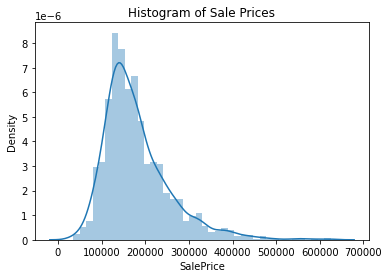

In [ ]:
# Variace of the Target: Sale price
print('Variance : ',np.var(Y))
coeficient_normalized_unprepared=1
coeficient_normalized_prepared=1
Y.value_counts()
sns.distplot(Y)
plt.title('Histogram of Sale Prices')

#First Dataset 

Making first data set from main Dataset

Dummy: to transfer categorical features to value

Imputer: to replace Nan with meaan of values of each feature

Normalizing the data and eliminating the outlier from target

Splitting data and Target to train and test data

In [ ]:
Xdummy = pd.get_dummies(X)

Yc_n_u = Y*coeficient_normalized_unprepared
yc_n = y*coeficient_normalized_prepared
y_testc_n = y_test*coeficient_normalized_prepared

#Imputer: replace value istead of NaN (Avearage od the feature values instead of NaN and missing values)
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(Xdummy)
ImpX = imputer.transform(Xdummy)
print('X1 : ',np.shape(ImpX))
DFX1 = pd.DataFrame(ImpX,index=Xdummy.index,columns=Xdummy.columns)
X1 = ImpX
Y1 = Yc_n_u
y = y*coeficient_normalized_prepared
y_test = y_test*coeficient_normalized_prepared

X1 :  (1456, 301)


Normalization and Splitting

In [ ]:
scalerX = MinMaxScaler()
scalerX.fit(X1)
X1scaled = scalerX.transform(X1)
scalerY = MinMaxScaler()
Xtrain1,Xtest1,Ytrain1,Ytest1=train_test_split(X1scaled,Y1,test_size=0.2, random_state=42)
print(np.shape(Xtrain1))
print(np.shape(Ytrain1))
print(np.shape(Xtest1))
print(np.shape(Ytest1))

(1164, 301)
(1164,)
(292, 301)
(292,)


Making the first Neural Network and Fitting the data

In [ ]:
model1 = Sequential()
model1.add(Dense(50, input_shape=(301,), activation='tanh'))
model1.add(Dense(30, activation='tanh'))
model1.add(Dense(10, activation='tanh'))
model1.add(Dense(1))
model1.compile(optimizer='rmsprop', loss='mse') #or SGD
model1.fit(Xtrain1, Ytrain1, epochs = 100)

Epoch 1/100
37/37 [==============================] - 1s 2ms/step - loss: 38698165463.5789
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 41330284220.6316
Epoch 3/100
37/37 [==============================] - 0s 1ms/step - loss: 38975152235.7895
Epoch 4/100
37/37 [==============================] - 0s 1ms/step - loss: 40182796719.1579
Epoch 5/100
37/37 [==============================] - 0s 1ms/step - loss: 39396761923.3684
Epoch 6/100
37/37 [==============================] - 0s 1ms/step - loss: 38345699866.9474
Epoch 7/100
37/37 [==============================] - 0s 1ms/step - loss: 38548524840.4211
Epoch 8/100
37/37 [==============================] - 0s 1ms/step - loss: 39042472151.5789
Epoch 9/100
37/37 [==============================] - 0s 1ms/step - loss: 38664055861.8947
Epoch 10/100
37/37 [==============================] - 0s 2ms/step - loss: 39929922937.2632
Epoch 11/100
37/37 [==============================] - 0s 1ms/step - loss: 39768545064.4211
Epoch 12

See the Mean Qquared Error : less is better and high is nor acceptable and it means the NN algorithm does not work well

In [ ]:
predicta = model1.predict(Xtrain1)
predictb = model1.predict(Xtest1)
A = metrics.mean_squared_error(Ytrain1,predicta,squared=False)
print('Mean Squred Error for First Dataset without preprocessing - Train : ',A)
A = metrics.mean_squared_error(Ytest1,predictb,squared=False)
print('Mean Squred Error for First Dataset without preprocessing - Test : ',A)

if A > .3:
  print('The algorithm result is not acceptable!')

Mean Squred Error for First Dataset without preprocessing - Train :  197221.7333533718
Mean Squred Error for First Dataset without preprocessing - Test :  189755.23681777992
The algorithm result is not acceptable!


#Second Dataset

selecting 21 important features only by a glance of the correlation and pairplot 

In [ ]:
print(houseData.head(3))
X2 = houseData[['LotFrontage', 'LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','WoodDeckSF','TotRmsAbvGrd','GarageYrBlt','GarageYrBlt','OpenPorchSF','EnclosedPorch','ScreenPorch']].copy()
print(X2.corr())
print(X2.describe())

Y2 = Y1
print(X2.isnull().sum())

    MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
Id                                    ...                                  
1           60       RL         65.0  ...        WD        Normal    208500
2           20       RL         80.0  ...        WD        Normal    181500
3           60       RL         68.0  ...        WD        Normal    223500

[3 rows x 80 columns]
               LotFrontage   LotArea  ...  EnclosedPorch  ScreenPorch
LotFrontage       1.000000  0.275648  ...       0.015476     0.043559
LotArea           0.275648  1.000000  ...      -0.016108     0.045620
OverallQual       0.209889  0.088719  ...      -0.112407     0.067732
OverallCond      -0.049580 -0.002832  ...       0.070103     0.054617
YearBuilt         0.108733  0.006590  ...      -0.386904    -0.049703
YearRemodAdd      0.074181  0.006930  ...      -0.193348    -0.038176
MasVnrArea        0.148984  0.080357  ...      -0.109156     0.066081
BsmtFinSF1        0.122347  0.173426 

Replacing missing values and Nan with average value of the feature

In [ ]:
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(X2)
impX2m = imputer.transform(X2)
X2m = pd.DataFrame(impX2m,index=X2.index,columns=X2.columns)
print(X2m.isnull().sum())

LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
WoodDeckSF       0
TotRmsAbvGrd     0
GarageYrBlt      0
GarageYrBlt      0
OpenPorchSF      0
EnclosedPorch    0
ScreenPorch      0
dtype: int64


Normalizing and splitting the second Dataset

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X2m)
X2scaled = scaler.transform(X2m)
print(np.shape(X2scaled))
print(np.shape(Y2))
Xtrain2,Xtest2,Ytrain2,Ytest2=train_test_split(X2scaled,Y2,test_size=0.2, random_state=42)
print(np.shape(Xtrain2))
print(np.shape(Ytrain2))
print(np.shape(Xtest2))
print(np.shape(Ytest2))


(1456, 21)
(1456,)
(1164, 21)
(1164,)
(292, 21)
(292,)


Create our Model


In [ ]:
model2 = Sequential()
model2.add(Dense(20,input_shape=(21,), activation='tanh'))
model2.add(Dense(15,activation='tanh'))
model2.add(Dense(1))
model2.compile(optimizer = 'rmsprop', loss='mse')
model2.fit(Xtrain2, Ytrain2, epochs = 100)


Epoch 1/100
37/37 [==============================] - 0s 1ms/step - loss: 39600213207.5789
Epoch 2/100
37/37 [==============================] - 0s 1ms/step - loss: 39772663700.2105
Epoch 3/100
37/37 [==============================] - 0s 1ms/step - loss: 39851844446.3158
Epoch 4/100
37/37 [==============================] - 0s 1ms/step - loss: 39897454484.2105
Epoch 5/100
37/37 [==============================] - 0s 1ms/step - loss: 40140056791.5789
Epoch 6/100
37/37 [==============================] - 0s 1ms/step - loss: 38124257387.7895
Epoch 7/100
37/37 [==============================] - 0s 1ms/step - loss: 38292897037.4737
Epoch 8/100
37/37 [==============================] - 0s 1ms/step - loss: 38065625303.5789
Epoch 9/100
37/37 [==============================] - 0s 2ms/step - loss: 37863676119.5789
Epoch 10/100
37/37 [==============================] - 0s 1ms/step - loss: 37698508422.7368
Epoch 11/100
37/37 [==============================] - 0s 1ms/step - loss: 40480130856.4211
Epoch 12

In [ ]:
evaluatetrain = model2.evaluate(Xtrain2,Ytrain2)
evaluatetest = model2.evaluate(Xtest2,Ytest2)
print(evaluatetrain)
print(evaluatetest)

10/10 [==============================] - 0s 2ms/step - loss: 36000337920.0000
38889480192.0
36000337920.0


In [ ]:
predictb = model2.predict(Xtrain2)
predicta = model2.predict(Xtest2)
A2 = metrics.mean_squared_error(Ytrain2,predictb,squared=False)
A1 = metrics.mean_squared_error(Ytest2,predicta,squared=False)
print('Mean Squred Error for First Database: Train {} and Test {}'.format(A1,A2))
y = coeficient_normalized_prepared*yc_n
y_test = coeficient_normalized_prepared*y_testc_n
A = metrics.mean_squared_error(Ytest2,predicta,squared=False)

if A > .3:
  print ('The algorithm result is not acceptable!')

Mean Squred Error for First Database: Train 189737.55298687986 and Test 197204.1455228001
The algorithm result is not acceptable!


#3 : Third Dataset

The joint Data set that is applied for Lesso Regression and Super Vector Machines(SVMs)

In [ ]:
X1train = X_complete
X2train = X_Intuitive
X3train = Principal_Components_perf
X1test = X_test_complete
X2test = X_test_Intuitive
X3test = X_test_transformed

#3-1: Dataset : Complete
#3-2: Dataset : Intuitive
#3-3: Dataset : Principal Component
Y1train = y
Y2train = y
Y3train = y
Y1test = y_test
Y2test = y_test
Y3test = y_test

3-1: Dataset : Complete / 3-2: Dataset : Intuitive / 3-3: Dataset : Principal Component

Fitting Data on the Neural Network Dataset
#Data set 3  # 1 : complete

In [ ]:
#Data set 3-1  Complete
model3 = Sequential()
model3.add(Dense(50,input_shape=(118,), activation='tanh'))
model3.add(Dense(30, activation='tanh'))
model3.add(Dense(20,activation='tanh'))
model3.add(Dense(1))
model3.compile(optimizer = 'SGD', loss='mse')
model3.fit(X1train, Y1train, epochs = 200)

Epoch 1/200
37/37 [==============================] - 0s 1ms/step - loss: 27.5179
Epoch 2/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1486
Epoch 3/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1233
Epoch 4/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1186
Epoch 5/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1161
Epoch 6/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0973
Epoch 7/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0919
Epoch 8/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0678
Epoch 9/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0685
Epoch 10/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0688
Epoch 11/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0625
Epoch 12/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0585
Epoch 13/200
37/37 [================

In [ ]:
print('3-1 Complete dataset')
print('Evaluate Train 3-1 : ',model3.evaluate(X1train,Y1train))
print('Evaluate Test 3-1 : ',model3.evaluate(X1test,Y1test))

Ypredict = model3.predict(X1train)
print('Train Set : Mean Squred Error for 31:')
print(metrics.mean_squared_error(Y1train,Ypredict,squared=False))

Ypredict = model3.predict(X1test)
print('Test Set : Mean Squred Error for 31:')
print(metrics.mean_squared_error(Y1test,Ypredict,squared=False))

3-1 Complete dataset
37/37 [==============================] - 0s 969us/step - loss: 0.0119
Evaluate Train 3-1 :  0.011941399425268173
10/10 [==============================] - 0s 2ms/step - loss: 0.0210
Evaluate Test 3-1 :  0.021001199260354042
Train Set : Mean Squred Error for 31:
0.10927672826163821
Test Set : Mean Squred Error for 31:
0.14491796315399716


In [ ]:
#Calculating rmse in dollars 3-1
print("RMSE in dollars for 3-1:", round(mean_squared_error(np.exp(Ypredict),np.exp(Y1test),squared=False),2))

RMSE in dollars for 3-1: 28317.53


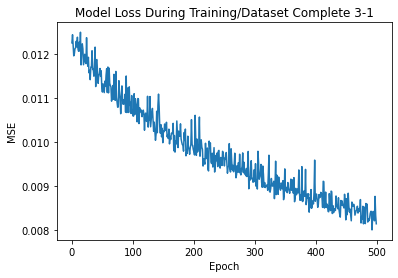

In [ ]:
history = model3.fit(X1train, Y1train, epochs = 500, verbose= 0)
plt.figure()
plt.plot(history.history['loss'])
plt.title('Model Loss During Training/Dataset Complete 3-1')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

Fitting Data on the Neural Network Dataset
#Data set 3  # 2 : Intutive

In [ ]:
#Data set 3-2 Intutive
model4 = Sequential()
model4.add(Dense(15,input_shape=(11,), activation='tanh'))
model4.add(Dense(15, activation='tanh'))
model4.add(Dense(1))
model4.compile(optimizer = 'rmsprop', loss='mse')
model4.fit(X2train, Y2train, epochs = 150)

Epoch 1/150
37/37 [==============================] - 0s 1ms/step - loss: 144.3200
Epoch 2/150
37/37 [==============================] - 0s 1ms/step - loss: 90.6668
Epoch 3/150
37/37 [==============================] - 0s 1ms/step - loss: 58.5064
Epoch 4/150
37/37 [==============================] - 0s 1ms/step - loss: 39.5357
Epoch 5/150
37/37 [==============================] - 0s 1ms/step - loss: 28.7414
Epoch 6/150
37/37 [==============================] - 0s 1ms/step - loss: 21.3179
Epoch 7/150
37/37 [==============================] - 0s 1ms/step - loss: 16.0684
Epoch 8/150
37/37 [==============================] - 0s 1ms/step - loss: 11.6396
Epoch 9/150
37/37 [==============================] - 0s 1ms/step - loss: 8.0055
Epoch 10/150
37/37 [==============================] - 0s 1ms/step - loss: 5.1245
Epoch 11/150
37/37 [==============================] - 0s 1ms/step - loss: 3.0560
Epoch 12/150
37/37 [==============================] - 0s 1ms/step - loss: 1.4983
Epoch 13/150
37/37 [========

In [ ]:
print('3-2 Intutive dataset')
print('Evaluate Train 3-2 :', model4.evaluate(X2train,Y2train))
print('Evaluate Test 3-2 :', model4.evaluate(X2test,Y2test))

Ypredict = model4.predict(X2train)
print('Train Set : Mean Squred Error for 32:')
print(metrics.mean_squared_error(Y2train,Ypredict,squared=False))

Ypredict = model4.predict(X2test)
print('Test Set : Mean Squred Error for 32:')
print(metrics.mean_squared_error(Y2test,Ypredict,squared=False))

3-2 Intutive dataset
37/37 [==============================] - 0s 977us/step - loss: 0.0227
Evaluate Train 3-2 : 0.022741492837667465
10/10 [==============================] - 0s 1ms/step - loss: 0.0244
Evaluate Test 3-2 : 0.02439458668231964
Train Set : Mean Squred Error for 32:
0.1508028378505077
Test Set : Mean Squred Error for 32:
0.1561876390347443


In [ ]:
#Calculating rmse in dollars 3-1
print("RMSE in dollars 3-1", round(mean_squared_error(np.exp(Ypredict),np.exp(Y2test),squared=False),2))

RMSE in dollars 3-1 32331.83


#Data set 3 # 3 Principal Component

In [ ]:
# Dataset 3-3
model5 = Sequential()
model5.add(Dense(30,input_shape=(60,), activation='tanh'))
model5.add(Dense(15, activation='tanh'))
model5.add(Dense(10,activation='tanh'))
model5.add(Dense(1))
model5.compile(optimizer = 'SGD', loss='mse')
model5.fit(X3train, Y3train, epochs = 200)

Epoch 1/200
37/37 [==============================] - 0s 1ms/step - loss: 45.4677
Epoch 2/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1550
Epoch 3/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1316
Epoch 4/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1043
Epoch 5/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0980
Epoch 6/200
37/37 [==============================] - 0s 999us/step - loss: 0.0915
Epoch 7/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0782
Epoch 8/200
37/37 [==============================] - 0s 998us/step - loss: 0.0721
Epoch 9/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0743
Epoch 10/200
37/37 [==============================] - 0s 995us/step - loss: 0.0716
Epoch 11/200
37/37 [==============================] - 0s 1ms/step - loss: 0.0636
Epoch 12/200
37/37 [==============================] - 0s 989us/step - loss: 0.0642
Epoch 13/200
37/37 [========

In [ ]:
print('3-3 Principal Components dataset')
print('Evaluate Train 3-3 :', model5.evaluate(X3train,Y3train))
print('Evaluate Test 3-3 :', model5.evaluate(X3test,Y3test))

Ypredict = model5.predict(X3train)
print('Train Set : Mean Squred Error for 33:')
print(metrics.mean_squared_error(Y3train,Ypredict,squared=False))

Ypredict = model5.predict(X3test)
print('Test Set : Mean Squred Error for 33:')
print(metrics.mean_squared_error(Y3test,Ypredict,squared=False))


3-3 Principal Components dataset
37/37 [==============================] - 0s 921us/step - loss: 0.0175
Evaluate Train 3-3 : 0.017531946301460266
10/10 [==============================] - 0s 1ms/step - loss: 0.0246
Evaluate Test 3-3 : 0.024564668536186218
Train Set : Mean Squred Error for 33:
0.1324082646880265
Test Set : Mean Squred Error for 33:
0.15673125467571358


In [ ]:
#Calculating rmse in dollars 3-1
print("RMSE in dollars 3-1", round(mean_squared_error(np.exp(Ypredict),np.exp(Y3test),squared=False),2))

RMSE in dollars 3-1 32932.22


# 4 :  Neural Network - Hyperparameter

In [ ]:
#3-1 Complete
def create_model(optimizer = 'rmsprop'):
    input_seq = Input(shape=(118,))
    hidden_1 = Dense(50, activation = 'tanh')(input_seq)
    hidden_2 = Dense(30, activation = 'tanh')(hidden_1)
    hidden_3 = Dense(20, activation = 'tanh')(hidden_2)
    output_seq = Dense(1, activation= 'tanh')(hidden_3)
    model_class = Model(input_seq,output_seq)
    model_class.compile(optimizer = optimizer, loss='mse', metrics=['accuracy'])
    return model_class

In [ ]:
optimizers = ['rmsprop', 'SGD','adam']
batches = [5,10,20]
epochs = [50,100,250]
param_grid = dict(batch_size=batches, optimizer=optimizers, epochs=epochs)
hp_model = KerasRegressor(build_fn=create_model, verbose=0)
grid = GridSearchCV(estimator = hp_model, param_grid = param_grid)
grid_result = grid.fit(X1train, Y1train)
print(grid_result.best_score_)
print(grid_result.best_params_)

-121.61022338867187
{'batch_size': 20, 'epochs': 50, 'optimizer': 'rmsprop'}


Applying parameters from Hyperparameters on Neural Network

In [ ]:
# insert number of baches and number of Epochs and Optimizer from the Hyperparameter section 
modelhp = Sequential()
modelhp.add(Dense(50,input_shape=(118,), activation='tanh'))
modelhp.add(Dense(30, activation='tanh'))
modelhp.add(Dense(20,activation='tanh'))
modelhp.add(Dense(1))

modelhp.compile(optimizer = 'rmsprop', loss='mse')
# insert number of Baches and number of Epochs and Optimizer from the Hyperparameter section
modelhp.fit(X1train, Y1train, epochs = 50 , batch_size=20)
predict = modelhp.predict(X1test)
metrics.mean_squared_error(Y1test,predict,squared=False)

Epoch 1/50
59/59 [==============================] - 1s 1ms/step - loss: 68.3740
Epoch 2/50
59/59 [==============================] - 0s 1ms/step - loss: 25.4392
Epoch 3/50
59/59 [==============================] - 0s 1ms/step - loss: 14.3178
Epoch 4/50
59/59 [==============================] - 0s 1ms/step - loss: 6.8280
Epoch 5/50
59/59 [==============================] - 0s 1ms/step - loss: 2.2634
Epoch 6/50
59/59 [==============================] - 0s 1ms/step - loss: 0.3582
Epoch 7/50
59/59 [==============================] - 0s 1ms/step - loss: 0.1724
Epoch 8/50
59/59 [==============================] - 0s 1ms/step - loss: 0.1547
Epoch 9/50
59/59 [==============================] - 0s 1ms/step - loss: 0.1575
Epoch 10/50
59/59 [==============================] - 0s 1ms/step - loss: 0.1570
Epoch 11/50
59/59 [==============================] - 0s 1ms/step - loss: 0.1011
Epoch 12/50
59/59 [==============================] - 0s 1ms/step - loss: 0.0584
Epoch 13/50
59/59 [===========================

0.13740886392613114

In [ ]:
print('After Hyperparameter- Evaluate Train 3-3 : ',modelhp.evaluate(X1train,Y1train))
print('After Hyperparameter- Evaluate Test 3-3 : ',modelhp.evaluate(X1test,Y1test))
Ypredict = modelhp.predict(X1test)
print('After Hyperparameter on number of epoches and baches and the type of optimizer,Mean Squred Error for 3-3:')
metrics.mean_squared_error(Y1test,Ypredict,squared=False)

37/37 [==============================] - 0s 917us/step - loss: 0.0095
After Hyperparameter- Evaluate Train 3-3 :  0.009535974822938442
10/10 [==============================] - 0s 1ms/step - loss: 0.0189
After Hyperparameter- Evaluate Test 3-3 :  0.018881192430853844
After Hyperparameter on number of epoches and baches and the type of optimizer,Mean Squred Error for 3-3:


0.13740886392613114

#*5* :  Neural Network - Cross Validation

K- Fold Cross Validation For Parameter Tuning
Split the dataset into k equal partitions.
Use first fold as testing data and union of other folds as training data and calculate testing accuracy.
Repeat step 1 and step 2. Use different set as test data different times. ...
Take the average of these test accuracy as the accuracy of the sample.


In [ ]:
#Create Function That Constructs Neural Network
# Taken from: https://chrisalbon.com/deep_learning/keras/k-fold_cross-validating_neural_networks/
np.random.seed(0)

X1com = np.concatenate((X1train,X1test),axis=0)
print(X1com.shape)
Y1com = np.concatenate((Y1train,Y1test),axis=0)
print(Y1com.shape)

(1456, 118)
(1456,)


In [ ]:
# Create function returning a compiled network
def create_network():
  model = Sequential()
  model.add(Dense(50,input_shape=(118,), activation='tanh'))
  model.add(Dense(30, activation='tanh'))
  model.add(Dense(20,activation='tanh'))
  model.add(Dense(1))
  model.compile(optimizer = 'rmsprop', loss='mse')
  return model

#Wrap Function In KerasClassifier. Wrap Keras model so it can be used by scikit-learn
neural_network = KerasRegressor(build_fn=create_network,
                                 epochs=50, 
                                 batch_size=20, 
                                 verbose=0)

# Conduct k-Fold Cross-Validation Using scikit-learn
# Evaluate neural network using three-fold cross-validation
cross_val_score(neural_network, X1com, Y1com, cv=5)


array([-0.01384911, -0.04740969, -0.16113609, -0.02543146, -0.088975  ])